# The Navier-Stokes equations

In this example, we will consider the incompressible Navier--Stokes
equations. This is one of the most fundamental equation in computational 
fluid dynamics. This problem combines many of the challenges from our
previously studied problems: time-dependence, nonlinearity, and
vector-valued variables. We will consider how to solve such 
a complex problem using FEniCS.

## PDE problem

The incompressible Navier--Stokes equations form a system of equations
for the velocity $\boldsymbol{u}$ and pressure $p$ in an incompressible fluid:

\begin{align}
  \label{ftut1:ns:momentum}
\rho\left(\dot{\boldsymbol{u}}+\boldsymbol{u}\cdot\boldsymbol{\nabla}\boldsymbol{u}\right) & =\boldsymbol{\nabla}\cdot\boldsymbol{\sigma}(\boldsymbol{u},p)+\boldsymbol{f},\\
  \label{ftut1:ns:continuity}
  \boldsymbol{\nabla} \cdot \boldsymbol{u} &= 0,
\end{align}
where $\dot{\boldsymbol{u}}$ denotes $\partial\boldsymbol{u}/\partial t$, the acceleration, and 
$\boldsymbol{u} \cdot \boldsymbol{\nabla}\boldsymbol{u}$ denotes a vector
$\boldsymbol{w}$ with elements
$w_i = \sum_j \left(u_j \dfrac{\partial}{\partial x_j}\right) u_i
= \sum_j u_j \dfrac{\partial u_i}{\partial x_j}.$

The above two equations are referred to as *momentum equation* and *continuity equation*, respectively. 
The right-hand side $\boldsymbol{f}$ of (\ref{ftut1:ns:momentum}) is a given force per unit volume and
just as for the equations of linear elasticity,
$\boldsymbol{\sigma}(\boldsymbol{u}, p)$ denotes the stress tensor, which for a Newtonian fluid
is given by
\begin{equation}
  \boldsymbol{\sigma}(\boldsymbol{u}, p) = 2\mu\boldsymbol{\epsilon}(\boldsymbol{u}) - p\boldsymbol{I},
\end{equation}
where $\boldsymbol{\epsilon}(\boldsymbol{u})$ is the strain-rate tensor

$$ \boldsymbol{\epsilon}(\boldsymbol{u}) = \frac{1}{2}\left(\boldsymbol{\nabla} \boldsymbol{u} + (\boldsymbol{\nabla} \boldsymbol{u})^T\right).$$

The parameter $\mu$ is the dynamic viscosity. Note that the momentum
equation (\ref{ftut1:ns:momentum}) is very similar to the elasticity
equation. The difference is in the
two additional terms $\rho(\dot{\boldsymbol{u}} + \boldsymbol{u} \cdot \boldsymbol{\nabla} \boldsymbol{u})$ and the different
expression for the stress tensor. The two extra terms express the
acceleration balanced by the force $\boldsymbol{F} = \boldsymbol{\nabla}\cdot\boldsymbol{\sigma} + \boldsymbol{f}$ per unit volume in Newton's second law of motion.

## Variational formulation

To derive the variaitonal form, we introduce a *vector* test function
$\boldsymbol{v}\in \boldsymbol{\mathcal{V}}$, where $\boldsymbol{\mathcal{V}}$ is a vector-valued test function space,
just as for the elasticity problem.
For conciseness, we will use the short-hand notation
$$
  \langle \boldsymbol{v}, \boldsymbol{w}\rangle = \int_{\Omega} \boldsymbol{v}\cdot\boldsymbol{w}\ \mathrm{d}\boldsymbol{x}, \quad
  \langle \boldsymbol{v}, \boldsymbol{w}\rangle_{\partial\Omega} = \int_{\partial\Omega} \boldsymbol{v}\cdot\boldsymbol{w}\ \mathrm{d}\boldsymbol{s},
$$
where $\mathrm{d}\boldsymbol{x}$ and $\mathrm{d}\boldsymbol{s}$ denote the volume and surface measures, respectively.

Let us first consider the momentum equation. The variational form is
$$
\langle\rho\left(\dot{\boldsymbol{u}}+\boldsymbol{u}\cdot\boldsymbol{\nabla}\boldsymbol{u}\right),\boldsymbol{v}\rangle=\langle\boldsymbol{\nabla}\cdot\boldsymbol{\sigma}(\boldsymbol{u},p),\boldsymbol{v}\rangle+\langle\boldsymbol{f},\boldsymbol{v}\rangle.
$$
Using integration by parts and the fact that $\boldsymbol{\sigma}$ is a symmetric tensor, we obtain
$$
\langle-\boldsymbol{\nabla}\cdot\boldsymbol{\sigma},\boldsymbol{v}\rangle=\langle\boldsymbol{\sigma},\boldsymbol{\epsilon}(\boldsymbol{v})\rangle-\langle\boldsymbol{T},\boldsymbol{v}\rangle_{\partial\Omega},
$$
where $\boldsymbol{T} = \boldsymbol{\sigma}(\boldsymbol{u}, p)\cdot \boldsymbol{n}$ is the boundary traction. Therefore, 
\begin{equation}
\label{eq:navier_stokes:momment:varform}
\langle\rho\dot{\boldsymbol{u}},\boldsymbol{v}\rangle+\langle\rho\boldsymbol{u}\cdot\boldsymbol{\nabla}\boldsymbol{u},\boldsymbol{v}\rangle=-\langle\boldsymbol{\sigma},\boldsymbol{\epsilon}(\boldsymbol{v})\rangle+\langle\boldsymbol{T},\boldsymbol{v}\rangle_{\partial\Omega}+\langle\boldsymbol{f},\boldsymbol{v}\rangle.
\end{equation}

It is clear that this problem is nonlinear in $\boldsymbol{u}$. If
we solve it directly, just as in the case of heat equations, we
will need to solve a nonlinear equation, an dthe resulting linear
system will have a so-called *saddle point structure* and 
requires special techniques (special preconditioners and iterative methods) 
to be solved efficiently. Instead, we will apply a simpler and often 
very efficient approach, known as a *splitting method*. 

### Splitting methods
<!-- idx{splitting method}
idx{Chorin's method}
idx{incremental pressure correction scheme}-->

The idea of the splitting methods is to
consider the two equations (\ref{ftut1:ns:momentum}) and
(\ref{ftut1:ns:continuity}) separately. There exist many splitting
strategies for the incompressible Navier--Stokes equations. One of the
oldest is the method proposed by Chorin <!--\cite{Chorin1968}--> and
Temam, <!--\cite{Temam1969}--> often referred to as *Chorin's method*. We will
use a modified version of Chorin's method, the so-called incremental
pressure correction scheme (IPCS), <!--due to \cite{Goda1979}--> which gives
improved accuracy compared to the original scheme at little extra
cost. The IPCS scheme involves three steps, which we will address them one by one.

#### Step 1: solving the continuity equation

First, we compute an *intermediate
velocity* $\tilde{\boldsymbol{u}}$ by advancing the momentum equation
(\ref{ftut1:ns:momentum}) by a midpoint finite difference scheme in
time, but using the pressure $p_{k}$ from the
previous time interval. We will also linearize the nonlinear convective
term by using the known velocity $\boldsymbol{u}_{k}$ from the previous time step:
$\boldsymbol{u}_{k}\cdot\boldsymbol{\nabla} \boldsymbol{u}_{k}$, where 
$k$ denote the index of the time step.

The variational problem (\ref{eq:navier_stokes:momment:varform}) is then approximated as
\begin{equation}
\langle\rho(\tilde{\boldsymbol{u}}-\boldsymbol{u}_{k})/\Delta t,\boldsymbol{v}\rangle+\langle\rho\boldsymbol{u}_{k}\cdot\boldsymbol{\nabla}\boldsymbol{u}_{k},\boldsymbol{v}\rangle=-\langle\boldsymbol{\sigma}(\boldsymbol{u}_{k+\frac{1}{2}},p_{k}),\boldsymbol{\epsilon}(\boldsymbol{v})\rangle+\langle\boldsymbol{\sigma}(\boldsymbol{u}_{k+\frac{1}{2}},p_{k})\cdot\boldsymbol{n},\boldsymbol{v}\rangle_{\partial\Omega}+\langle\boldsymbol{f}_{k+1},\boldsymbol{v}\rangle,
\label{ftut1:ipcs1}
\end{equation}
Here, we use $\boldsymbol{u}_{k+\frac{1}{2}}$
to denote the value of $\boldsymbol{u}$ at the midpoint of the time interval, 
usually approximated by an arithmetic mean:
$$
\boldsymbol{u}_{k+\frac{1}{2}} \approx (\boldsymbol{u}_k + \boldsymbol{u}_{k+1}) / 2,
$$
where $\boldsymbol{u}_{k+1}=\tilde{\boldsymbol{u}}$, the intermediate solution.
This problem is now linear in $\tilde{\boldsymbol{u}}$.

<!--
More specifically,
\begin{align}
      & \langle\rho(\tilde{\boldsymbol{u}}-\boldsymbol{u}_{k})/\Delta t,\boldsymbol{v}\rangle
      + \langle\rho\boldsymbol{u}_{k}\cdot\boldsymbol{\nabla}\boldsymbol{u}_{k},\boldsymbol{v}\rangle
      + \nonumber
        \langle\boldsymbol{\sigma}(\boldsymbol{u}_{k+\frac{1}{2}},p_{k}),\boldsymbol{\epsilon}(\boldsymbol{v})\rangle
\\
      &\quad\quad\quad\quad\quad
      + \langle p_{k}\boldsymbol{n},\boldsymbol{v}\rangle_{\partial\Omega}
      - \langle\mu\boldsymbol{\nabla}\boldsymbol{u}_{k+\frac{1}{2}}\cdot\boldsymbol{n},\boldsymbol{v}\rangle_{\partial\Omega}
      = \langle\boldsymbol{f}_{k+1},\boldsymbol{v}\rangle.
\end{align}-->

#### Step 2: computing the pressue

We may now use the computed intermediate velocity to
$\tilde{\boldsymbol{u}}$ obtained from step 1 to compute the 
new pressure $p_{k+1}$.

One way to think about this step is to subtract the Navier--Stokes
momentum equation (\ref{ftut1:ns:momentum}) expressed in terms of the
intermediate velocity $\tilde{\boldsymbol{u}}$ and the pressure $p_k$ from the
momentum equation expressed in terms of the velocity $\boldsymbol{u}_{k+1}$ and
pressure $p_{k+1}$. This results in the equation

\begin{equation} \label{ftut1:ipcs:step}
  (\boldsymbol{u}_{k+1} - \tilde{\boldsymbol{u}}) / \Delta t + \boldsymbol{\nabla} p_{k+1} - \boldsymbol{\nabla} p_k = 0.
\end{equation}

Taking the divergence and requiring that $\boldsymbol{\nabla} \cdot \boldsymbol{u}_{k+1} = 0$ by the
Navier--Stokes continuity equation (\ref{ftut1:ns:continuity}), we
obtain the equation $$-\boldsymbol{\nabla}\cdot \tilde{\boldsymbol{u}} / \Delta t + \boldsymbol{\nabla}^2 p_{k+1} -
\boldsymbol{\nabla}^2 p_k = 0,$$ 
which is a Poisson problem for the pressure $p^{k+1}$
resulting in the variational problem:

\begin{equation}
\label{ftut1:ipcs2}
  \langle \boldsymbol{\nabla} p_{k+1}, \boldsymbol{\nabla} q \rangle
  = \langle \boldsymbol{\nabla} p_{k}, \boldsymbol{\nabla} q \rangle
  -  \langle \boldsymbol{\nabla} \cdot \tilde{\boldsymbol{u}}, q \rangle/\Delta t.
\end{equation}

Note here $q$ is a scalar-valued test function from the pressure
space, whereas the test function $\boldsymbol{v}$ in (\ref{ftut1:ipcs1}) is a
vector-valued test function from the velocity space.



#### Step 3: correcting the volocity

Finally, we compute the corrected velocity $\boldsymbol{u}_{k+1}$ from the equation
(\ref{ftut1:ipcs:step}). Multiplying this equation by a test function
$v$, we obtain

\begin{equation}
\label{ftut1:ipcs3}
\langle\boldsymbol{u}_{k+1},\boldsymbol{v\rangle=\langle\boldsymbol{u}_{k+1},\boldsymbol{v}\rangle-\Delta t\langle\boldsymbol{\nabla}(p^{n+1}-p^{n}),\boldsymbol{v}\rangle.}
\end{equation}

In summary, we may thus solve the incompressible Navier--Stokes
equations efficiently by solving a sequence of three linear variational
problems in each time step.

### Treatment of boundary conditions

If we solve a problem with a free boundary, we can take $T = 0$ on the
boundary. However, if we compute the flow through a channel or a pipe
and want to model flow that continues into an "imaginary channel" at
the outflow, we need to treat this term with some care. We will take
the assumption that the derivative of the velocity in the direction
of the channel is zero at the outflow, corresponding to a flow that is
"fully developed" or doesn't change significantly downstream of the
outflow. Doing so, the remaining boundary term at the outflow becomes
$p\boldsymbol{n} - \mu\boldsymbol{\nabla} \boldsymbol{u} \cdot \boldsymbol{n}$.
<!--, which is the term appearing in the variational problem (ref{ftut1:ipcs1})-->


Note that this argument and
the implementation depends on the exact definition of $\boldsymbol{\nabla}\boldsymbol{u}$, as
either the matrix with components $\partial u_i / \partial x_j$ or
$\partial u_j / \partial x_i$. We here choose the latter, $\partial
u_j / \partial x_i$, which means that we must use the FEniCS operator
`nabla_grad` for the implementation. If we use the `grad` operator and
the definition $\partial u_i / \partial x_j$, we must instead keep the
terms $pn - \mu(\nabla u)^{\top} \cdot n$!

## FEniCS implementation

## Test problem: channel flow in 2-D

<!--idx{channel flow}-->

As a first test problem, we compute the flow between two infinite
plates, so-called channel or Poiseuille flow. As we shall see, this
problem has a known analytical solution. Let $H$ be the distance
between the plates and $L$ the length of the channel. There are no
body forces.

<!--idx{scaling}-->

### Scaling
We may scale the problem first to get rid of seemingly independent
physical parameters. The physics of this problem is governed by
viscous effects only, in the direction perpendicular to the flow, so a
time scale should be based on diffusion across the channel: $t_c =
H^2/\nu$. We let $U$, some characteristic inflow velocity, be the
velocity scale and $H$ the spatial scale. The pressure scale is taken
as the characteristic shear stress, $\mu U/H$, since this is a primary
example of shear flow.  Inserting $\bar x = x/H$, $\bar y = y/H$,
$\bar z = z/H$, $\bar u =u/U$, $\bar p = Hp/(\mu U)$, and $\bar t =
H^2/\nu$ in the equations results in the scaled Navier--Stokes
equations (dropping bars after the scaling):

<!--idx{Reynolds number}-->

\begin{align*}
\frac{\partial u}{\partial t} + \mathrm{Re}\, u\cdot\nabla u
&= -\nabla p + \nabla^2 u,\\
\nabla\cdot u &= 0.
\end{align*}

Here, $\mathrm{Re} = \varrho UH/\mu$ is the *Reynolds number*. Because
of the time and pressure scales, which are different from
convection-dominated fluid flow, the Reynolds number is associated
with the convective term and not the viscosity term.

For a specific engineering problem one wants to simulate a specific
fluid and set corresponding parameters. A general solver is therefore
most naturally implemented with dimensions and the original physical
parameters. However, scaling may greatly simplify numerical
simulations. First of all, it shows that all fluids behave in the
same way: it does not matter whether we have oil, gas, or water
flowing between two plates, and it does not matter how fast the flow
is (up to some criticial value of the Reynolds number where the flow
becomes unstable and transitions to a complicated turbulent flow of
totally different nature). This means that one simulation is enough
to cover all types of channel flow! In other applications, scaling
shows that it might be necessary to set just the fraction of some
parameters (dimensionless numbers) rather than the parameters
themselves. This simplifies exploring the input parameter space which
is often the purpose of simulation. Frequently, the scaled problem is
run by setting some of the input parameters with dimension to fixed
values (often unity).

### Boundary conditions
The boundary conditions can be set as $p=8$ at $x=0$, $p=0$ at $x=1$
and $u=(0, 0, 0)$ on the walls $y=0,1$. This defines the pressure drop
and should result in unit maximum velocity at the inlet and outlet and
a parabolic velocity profile without further specifications. Note that
it is only meaningful to solve the Navier--Stokes equations in 2D or
3D geometries, although the underlying mathematical problem collapses
to two 1D problems, one for $u_x(y)$ and one for $p(x)$.

The scaled model is not so easy to simulate using a standard
Navier--Stokes solver with dimensions. However, one can argue that the
convection term is zero, so the Re coefficient in front of this term
in the scaled PDEs is not important and can be set to unity. In that
case, setting $\varrho = \mu = 1$ in the original Navier--Stokes equations
resembles the scaled model.

### FEniCS implementation

We now describe the complete implementation of the solver in FEniCS.

### Import packages

We start by importing fenics and enforcing matplotlib.

In [1]:
from fenics import *
import numpy as np

%matplotlib inline

### Generate the mesh and define function space

Our previous examples have all started out with the creation of a mesh
and then the definition of a `FunctionSpace` on the mesh.

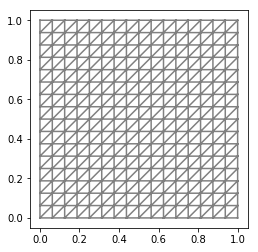

In [2]:
# Create mesh and define function spaces
mesh = UnitSquareMesh(16, 16)
plot(mesh)

For the Navier--Stokes splitting scheme we will need to define two function
spaces, one for the velocity and one for the pressure. One use one-degree
higher for velocity than pressure:

In [3]:
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

The first space `V` is a vector-valued function space for the velocity and the second space `Q` is a scalar-valued function space for the pressure. We use piecewise quadratic elements for the velocity and piecewise linear elements for the pressure. 

When creating a `VectorFunctionSpace` in FEniCS, the value-dimension (the length of the vectors) will be set equal to the geometric dimension of the finite element mesh. One can easily create vector-valued function spaces with other dimensions in FEniCS by adding the keyword parameter dim. For example,
```
V = VectorFunctionSpace(mesh, 'P', 2, dim=10)

```

**Note on stability of finite element spaces for the Navier–Stokes equations.** It is well-known that certain finite element spaces are not *stable* for the Navier–Stokes equations, or even for the simpler Stokes equations. The prime example of an unstable pair of finite element spaces is to use first degree continuous piecewise polynomials for both the velocity and the pressure. Using an unstable pair of spaces typically results in a solution with *spurious* (unwanted, non-physical) oscillations in the pressure solution. The simple remedy is to use continuous piecewise quadratic elements for the velocity and continuous piecewise linear elements for the pressure. Together, these elements form the so-called *Taylor-Hood* element. Spurious oscillations may occur also for splitting methods if an unstable element pair is used.

Since we have two different function spaces, we need to create two sets of trial and test functions:

In [4]:
# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

### Specify parameters

We specify material properties and time steps.

In [5]:
rho = 1            # density
mu = 1             # kinematic viscosity

T = 10.0           # final time
num_steps = 500    # number of time steps
dt = T / num_steps # time step size

### Define boundary conditions

Boundaries may be defined in FEniCS by defining Python functions that return `True` or `False` depending on whether a point should be considered part of the boundary, such as 
```
def boundary(x, on_boundary):
    return near(x[0], 0)
```
This function defines the boundary to be all points with $x$-coordinate equal to (near) zero. The `near` function comes from FEniCS and performs a test with tolerance: `abs(x[0] - 0) < 3E-16` so we do not run into rounding troubles.
A more efficient way is to give the boundary definition as a string of C++ code, so that the checking of which nodes belong to the boundary is performed in compiled C++ code. This can be done using the string
```
boundary = 'near(x[0], 0)'
```

For the current example, we will set three different boundary
conditions. First, we will set $u = 0$ at the walls of the channel;
that is, at $y = 0$ and $y = 1$. Second, we will set $p = 8$ at the
inflow ($x = 0$) and, finally, $p = 0$ at the outflow ($x = 1$). This
will result in a pressure gradient that will accelerate the flow from
the initial state with zero velocity. These boundary conditions may be
defined as follows:

In [6]:
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 1)'
walls    = 'near(x[1], 0) || near(x[1], 1)'

# Define boundary conditions
bcu_noslip  = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow  = DirichletBC(Q, Constant(8), inflow)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)

At the end, we collect the boundary conditions for the velocity and
pressure in Python lists so we can easily access them in the
following computation.

In [7]:
bcu = [bcu_noslip]
bcp = [bcp_inflow, bcp_outflow]

### Define the variational problem

We now move on to the definition of the variational forms. There are three variational problems to be defined, one for each step in the IPCS scheme. Let us look at the definition of the first variational problem. We start with some constants:

In [8]:
# Define expressions used in variational forms
f   = Constant((0, 0))
mu  = Constant(mu)
rho = Constant(rho)

There is an important detail in how we use parameters
such as the time step `dt` in the definition here. Since we 
might want to change these later, for example if we want to 
experiment with smaller or larger time steps, we wrap these
using a FEniCS `Constant`:

In [15]:
DT  = Constant(dt)

The assembly of matrices and vectors in FEniCS is based on code
generation. This means that whenever we change a variational problem,
FEniCS will have to generate new code, which may take a little
time. New code will also be generated and compiled when a float value
for the time step is changed. By wrapping this parameter using
`Constant`, FEniCS will treat the parameter as a generic constant and
not as a specific numerical value, which prevents repeated code
generation. In the case of the time step, we choose a new name `dT`
instead of `dt` for the `Constant` since we also want to use the
variable `dt` as a Python float as part of the time-stepping.

#### Defnine variational problem for step 1

We now set up the variational form for the first step
(\ref{ftut1:ipcs1}) in the solution process. Since the variational
problem contains a mix of known and unknown quantities we will use the
following naming convention: 
 - `u` is the unknown (mathematically $u_{k+1}$) as a trial function in the variational form, 
 - `u_` is the most recently computed approximation ($u_{k+1}$ available as a `Function` object), 
 - `u_k` is $u_k$, also a `Function` object.

The same convention goes for `p`, `p_` ($p_{k+1}$), and `p_k` ($p_k$).

In [10]:
# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

# Define functions for solutions at previous and current time steps
u_  = Function(V)
u_k = Function(V)

p_  = Function(Q)
p_k = Function(Q)

u_mid   = 0.5*(u_k + u)
n = FacetNormal(mesh)

# Define variational problem for step 1
F1 = rho*dot((u - u_k) / DT, v)*dx + \
     rho*dot(dot(u_k, nabla_grad(u_k)), v)*dx \
   + inner(sigma(u_mid, p_k), epsilon(v))*dx \
   + dot(p_k*n, v)*ds - dot(mu*nabla_grad(u_mid)*n, v)*ds \
   - dot(f, v)*dx

Note that we take advantage of the Python programming language to define our own operators `sigma` and `epsilon`. Using Python this way makes it easy to extend the mathematical language of FEniCS with special operators and constitutive laws.

It is a tedious process to separate the unknowns from known values from the variational form. FEniCS can sort out the bilinear form $a(u,v)$ and linear form $L(v)$ forms by the `lhs` and `rhs` functions. This is particularly convenient in longer and more complicated variational forms.

In [11]:
a1 = lhs(F1)
L1 = rhs(F1)

The splitting scheme requires the solution of a sequence of three variational problems in each time step. We have previously used the built-in FEniCS function `solve` to solve variational problems. Under the hood, when a user calls `solve(a == L, u, bc)`, FEniCS will perform the following steps:
```
A = assemble(A)
b = assemble(L)
bc.apply(A, b)
solve(A, u.vector(), b)
```
In the last step, FEniCS uses the overloaded `solve` function to solve
the linear system `AU = b` where `U` is the vector of degrees of
freedom for the function $u(x) = \sum_{j=1} U_j \phi_j(x)$.

In our implementation of the splitting scheme, we will make use of
these low-level commands to first assemble and then call solve. This
has the advantage that we may control when we assemble and when we
solve the linear system. In particular, since the matrices for the
three variational problems are all time-independent, it makes sense to
assemble them once and for all outside of the time-stepping loop:

In [12]:
## Assemble the matrix and apply boundary conditions
A1 = assemble(a1)

[bc.apply(A1) for bc in bcu]

[None]

Notice the Python *list comprehension* `[bc.apply(b1) for bc in bcu]`
which iterates over all `bc` in the list `bcu`. This is a convenient
and compact way to construct a loop that applies
all boundary conditions in a single line. Also, the code works if
we add more Dirichlet boundary conditions in the future.

Within the time-stepping loop, we may then assemble only the right-hand side vectors, apply boundary conditions, and call the solve function as here for the first of the three steps:

```
# Time-stepping
for k in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)
```

### Defnine variational problem for step 2

In [ ]:
# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

A2 = assemble(a2)

# Apply boundary conditions to matrices
[bc.apply(A2) for bc in bcp]

### Defnine variational problem for step 3

In [ ]:
# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A3 = assemble(a3)

### Time stepping

In [ ]:
# Time-stepping
t = 0
for n in range(num_steps):
    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    # Plot solution
    plot(u_)

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

In [ ]:

    # Compute error
    u_e = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_e = interpolate(u_e, V)
    error = np.abs(u_e.vector().array() - u_.vector().array()).max()
    print('t = %.2f: error = %.3g' % (t, error))
    print('max u:', u_.vector().array().max())



## Verification

We compute the error at the nodes as we have done before to verify
that our implementation is correct. Our Navier--Stokes solver computes
the solution to the time-dependent incompressible Navier--Stokes
equations, starting from the initial condition $u = (0, 0)$. We have
not specified the initial condition explicitly in our solver which
means that FEniCS will initialize all variables, in particular the
previous and current velocities `u_n` and `u_`, to zero. Since the
exact solution is quadratic, we expect the solution to be exact to
within machine precision at the nodes at infinite time. For our
implementation, the error quickly approaches zero and is approximately
$10^{-6}$ at time $T = 10$.

## Additional notes

### Exact solution of channel flow

The exact solution is derived by assuming $\boldsymbol{u}=(u_x(x,y,z),0,0)$, with
the $x$ axis pointing along the channel. Since $\boldsymbol{\nabla}\cdot \boldsymbol{u}=0$, 
$\boldsymbol{u}$ cannot depend on $x$. The physics of channel flow is also
two-dimensional so we can omit the $z$ coordinate (more precisely:
$\partial/\partial z=0$). Inserting $\boldsymbol{u}=(u_x,0,0)$ in the (scaled)
governing equations gives $u_x''(y) = \partial p/\partial x$.
Differentiating this equation with respect to $x$ shows that $\partial^2
p/\partial^2 x =0$ so $\partial
p/\partial x$ is a constant, here called $-\beta$. This is the driving
force of the flow and can be specified as a known parameter in the
problem.  Integrating $u_x''(y)=-\beta$ over the width of the channel,
$[0,1]$, and requiring $u=(0, 0, 0)$ at the channel walls, results in
$u_x=\frac{1}{2}\beta y(1-y)$. The characteristic inlet velocity
$U$ can be taken as the maximum inflow at $y=1/2$, implying
$\beta = 8$. The length of the channel, $L/H$ in the scaled
model, has no impact on the result, so for simplicity we just compute
on the unit square. Mathematically, the pressure must be prescribed
at a point, but since $p$ does not depend on $y$, we can set $p$ to a
known value, e.g. zero, along the outlet boundary $x=1$. The result
is $p(x)=8(1-x)$ and $u_x=4y(1-y)$.

### Exercise: Simulate channel flow in a 3D geometry

FEniCS solvers typically have the number of space dimensions
parameterized, so a 1D, 2D, and 3D code all look the same.
We shall demonstrate what this means by extending the 2D solver
to a simulator where the domain is a box
(the unit cube in the scaled model).

Set up boundary conditions for $u$ at all points on the boundary.
Set up boundary conditions for $p$ at all points on the boundary as
this is required by our Poisson equation for $p$ (but not in the
original mathematical model -- there, knowing $p$ at one point throughout
time is sufficient).

At the inlet $x=0$ we have the velocity completely described: $(u_x,0,0)$.
At the channel walls, $y=0$ and $y=1$, we also have the velocity
completely described: $u=(0,0,0)$ because of no-slip.
At the outlet x=1 we do not specify anything. This means that the
boundary integrals in Step 1 vanish and that $p=0$ and
$\partial u/\partial n = 0$, with $n$ as the $x$ direction,
implying ``no change'' with $x$, which is reasonable (since we know
that $\partial/\partial x=0$ because of incompressibility).
For the pressure we set $p=8$ at $x=0$ and $p=0$ at $x=1$ to
represent a scaled pressure gradient equal to 8 (which leads to
a unit maximum velocity). At $y=0$ and $y=1$ we do not specify anything,
which implies $\partial p/\partial y=0$. This is a condition much
discussed in the literature, but it works perfectly in channel flow
with straight walls.

The two remaining boundaries, $z=0$ and $z=1$, requires attention.
For the pressure, ``nothing happens'' in the $z$ direction so
$\partial p/\partial z=\partial p/\partial n=0$ is the condition.
This is automatically implemented by the finite element method.
For the velocity we also have a ``nothing happens'' criterion in the
3rd direction, and we can in addition use the assumption of $u_z=0$,
if needed.
The derivative criterion means $\partial u/\partial z=\partial u/\partial n=0$
in the boundary integrals. There is also an integral involving $pn_z$
in a component PDE with $u_z$ in all terms.

Modify the `navier_stokes_channel.py` file so it computes 3D channel flow.

<!--
We must switch the domain from `UnitSquareMesh` to `UnitCubeMesh`.
We must also switch all 3-vectors to 2-vectors, such as
replacing going from `(0,0)` to `(0,0,0)` in `bcu_noslip`. Similarly,
`f` and `u_e` must extend their 2-vectors to 3-vectors. -->